In [25]:
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import pandas as pd
import numpy as np
from pathlib import Path
import torchvision.transforms as transforms

class Nutrition5kDataset(Dataset):
    """
    Nutrition5K 数据集加载器
    
    Args:
        csv_file: CSV文件路径，包含ID和Value列
        data_root: 数据根目录
        split: 'train' 或 'test'
        transform: 图像变换
        use_depth: 是否使用深度图（默认False，baseline只用RGB）
    """
    def __init__(self, csv_file, data_root, split='train', 
                 transform=None, use_depth=False):
        self.df = pd.read_csv(csv_file)
        self.data_root = Path(data_root)
        self.split = split
        self.transform = transform
        self.use_depth = use_depth
        
        # 构建图像路径
        self.rgb_dir = self.data_root / split / 'color'
        if use_depth:
            self.depth_dir = self.data_root / split / 'depth_raw'
        
        print(f"加载 {split} 数据集: {len(self.df)} 个样本")
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        # 获取样本信息
        row = self.df.iloc[idx]
        dish_id = row['ID']
        
        # 加载RGB图像
        rgb_path = self.rgb_dir / dish_id / 'rgb.png'
        rgb = Image.open(rgb_path).convert('RGB')
        
        # 应用变换
        if self.transform:
            rgb = self.transform(rgb)
        
        # 准备返回值
        sample = {
            'image': rgb,
            'dish_id': dish_id
        }
        
        # 如果是训练集，添加标签
        if 'Value' in row:
            sample['calories'] = torch.tensor(row['Value'], dtype=torch.float32)
        
        # 如果使用深度图（baseline暂时不用）
        if self.use_depth:
            depth_path = self.depth_dir / dish_id / 'depth_raw.png'
            depth = Image.open(depth_path)
            depth = np.array(depth, dtype=np.float32) / 10000.0  # 转为米
            depth = torch.from_numpy(depth).unsqueeze(0)  # (1, H, W)
            sample['depth'] = depth
        
        return sample


def get_transforms(split='train', image_size=224):
    """
    获取数据变换
    
    Args:
        split: 'train' 或 'val'/'test'
        image_size: 目标图像尺寸
    """
    if split == 'train':
        # 训练集：数据增强
        return transforms.Compose([
            transforms.Resize((image_size, image_size)),
            transforms.RandomHorizontalFlip(p=0.5),  # 50%概率水平翻转
            transforms.RandomRotation(degrees=15),    # ±15度旋转
            transforms.ColorJitter(                   # 色彩抖动
                brightness=0.2,
                contrast=0.2,
                saturation=0.2,
                hue=0.1
            ),
            transforms.ToTensor(),
            transforms.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]
            )
        ])
    else:
        # 验证集/测试集：只做基本变换
        return transforms.Compose([
            transforms.Resize((image_size, image_size)),
            transforms.ToTensor(),
            transforms.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]
            )
        ])


def create_dataloaders(data_root, train_csv, batch_size=32, 
                       val_split=0.2, num_workers=0, image_size=224):
    """
    创建训练集和验证集的DataLoader
    
    Args:
        data_root: 数据根目录
        train_csv: 训练CSV文件路径
        batch_size: 批次大小
        val_split: 验证集比例（0.2 = 20%）
        num_workers: 数据加载线程数
        image_size: 图像尺寸
    
    Returns:
        train_loader, val_loader
    """
    # 读取完整训练集
    full_df = pd.read_csv(train_csv)
    
    # 划分训练集和验证集
    from sklearn.model_selection import train_test_split
    train_df, val_df = train_test_split(
        full_df, 
        test_size=val_split, 
        random_state=42,
        shuffle=True
    )
    
    # 保存临时CSV
    train_csv_path = Path(train_csv).parent / 'train_split.csv'
    val_csv_path = Path(train_csv).parent / 'val_split.csv'
    train_df.to_csv(train_csv_path, index=False)
    val_df.to_csv(val_csv_path, index=False)
    
    print(f"数据集划分: 训练={len(train_df)}, 验证={len(val_df)}")
    
    # 创建数据集
    train_dataset = Nutrition5kDataset(
        csv_file=train_csv_path,
        data_root=data_root,
        split='train',
        transform=get_transforms('train', image_size),
        use_depth=False  # baseline不用深度图
    )
    
    val_dataset = Nutrition5kDataset(
        csv_file=val_csv_path,
        data_root=data_root,
        split='train',  # 注意：验证集也来自train目录
        transform=get_transforms('val', image_size),
        use_depth=False
    )
    
    # 创建DataLoader
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True  # 加速GPU传输
    )
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True
    )
    
    return train_loader, val_loader


# 测试代码
if __name__ == '__main__':
    # 测试数据加载
    data_root = Path('Nutrition5K/Nutrition5K')
    train_csv = data_root / 'nutrition5k_train.csv'
    
    train_loader, val_loader = create_dataloaders(
        data_root=data_root,
        train_csv=train_csv,
        batch_size=16,
        val_split=0.2
    )
    
    # 获取一个batch查看
    batch = next(iter(train_loader))
    print(f"\nBatch信息:")
    print(f"  图像shape: {batch['image'].shape}")  # (B, 3, 224, 224)
    print(f"  卡路里shape: {batch['calories'].shape}")  # (B,)
    print(f"  卡路里值: {batch['calories'][:5]}")

数据集划分: 训练=2640, 验证=661
加载 train 数据集: 2640 个样本
加载 train 数据集: 661 个样本

Batch信息:
  图像shape: torch.Size([16, 3, 224, 224])
  卡路里shape: torch.Size([16])
  卡路里值: tensor([31.6200, 50.2953, 24.6556, 91.9700, 92.5544])


In [26]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class BaselineCNN(nn.Module):
    """
    Baseline CNN 用于卡路里预测
    
    架构：5个卷积块 + 2个全连接层
    输入：(B, 3, 224, 224) RGB图像
    输出：(B, 1) 卡路里预测值
    """
    def __init__(self, dropout_rate=0.5):
        super(BaselineCNN, self).__init__()
        
        # 卷积块 1: 3 -> 32
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2)  # 224 -> 112
        )
        
        # 卷积块 2: 32 -> 64
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2)  # 112 -> 56
        )
        
        # 卷积块 3: 64 -> 128
        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2)  # 56 -> 28
        )
        
        # 卷积块 4: 128 -> 256
        self.conv4 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2)  # 28 -> 14
        )
        
        # 卷积块 5: 256 -> 512
        self.conv5 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2)  # 14 -> 7
        )
        
        # 全局平均池化
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        
        # 全连接层
        self.fc = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate),
            nn.Linear(256, 1)  # 输出1个值
        )
        
        # 权重初始化
        self._initialize_weights()
    
    def _initialize_weights(self):
        """使用He初始化"""
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        """
        前向传播
        
        Args:
            x: (B, 3, 224, 224) RGB图像
        
        Returns:
            (B, 1) 卡路里预测值
        """
        x = self.conv1(x)   # (B, 32, 112, 112)
        x = self.conv2(x)   # (B, 64, 56, 56)
        x = self.conv3(x)   # (B, 128, 28, 28)
        x = self.conv4(x)   # (B, 256, 14, 14)
        x = self.conv5(x)   # (B, 512, 7, 7)
        
        # 全局平均池化
        x = self.global_avg_pool(x)  # (B, 512, 1, 1)
        x = x.view(x.size(0), -1)     # (B, 512)
        
        # 全连接层
        x = self.fc(x)  # (B, 1)
        
        # 确保输出非负（卡路里不能为负）
        x = F.relu(x)
        
        return x


def count_parameters(model):
    """计算模型参数量"""
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


# 测试代码
if __name__ == '__main__':
    # 创建模型
    model = BaselineCNN(dropout_rate=0.5)
    
    # 统计参数
    num_params = count_parameters(model)
    print(f"模型参数量: {num_params:,}")
    
    # 测试前向传播
    batch_size = 4
    dummy_input = torch.randn(batch_size, 3, 224, 224)
    
    print(f"\n输入shape: {dummy_input.shape}")
    
    # 前向传播
    output = model(dummy_input)
    print(f"输出shape: {output.shape}")
    print(f"输出值: {output.squeeze()}")
    
    # 检查梯度流
    print(f"\n模型可训练: {model.training}")
    print(f"第一层权重requires_grad: {model.conv1[0].weight.requires_grad}")

模型参数量: 4,847,777

输入shape: torch.Size([4, 3, 224, 224])
输出shape: torch.Size([4, 1])
输出值: tensor([0., 0., 0., 0.], grad_fn=<SqueezeBackward0>)

模型可训练: True
第一层权重requires_grad: True


In [27]:
import pandas as pd
import numpy as np

# 看训练集统计
train_df = pd.read_csv('Nutrition5K/Nutrition5K/nutrition5k_train_clean.csv')
print("训练集卡路里统计:")
print(f"最小值: {train_df['Value'].min():.1f}")
print(f"最大值: {train_df['Value'].max():.1f}")
print(f"均值: {train_df['Value'].mean():.1f}")
print(f"中位数: {train_df['Value'].median():.1f}")
print(f"标准差: {train_df['Value'].std():.1f}")

训练集卡路里统计:
最小值: 0.0
最大值: 3943.3
均值: 237.3
中位数: 186.8
标准差: 221.3


数据集诊断报告

[1] 读取数据...

完整数据集列名: ['ID', 'Value']
验证集列名: ['ID', 'Value']

✓ 识别到的列:
  ID列: 'ID'
  卡路里列: 'Value'
  ✓ 找到train_split.csv

样本统计:
  完整数据: 3300 样本
  训练集: 2640 样本
  验证集: 661 样本
  验证集占比: 20.0%

[2] 卡路里分布对比
----------------------------------------------------------------------
           训练集      验证集       差异   差异率%
样本数    2640.00   661.00 -1979.00 -74.96
均值      236.77   239.80     3.03   1.28
标准差     220.32   225.12     4.79   2.17
最小值       0.00     0.00     0.00    NaN
25%分位    64.34    50.14   -14.20 -22.07
中位数     190.01   174.02   -15.99  -8.42
75%分位   356.45   382.94    26.49   7.43
最大值    3943.33  1238.03 -2705.29 -68.60

[3] 分布一致性分析
----------------------------------------------------------------------
均值差异: 3.0 kcal (1.3%)
标准差差异: 4.8 kcal (2.2%)

KS检验统计量: 0.0514, p-value: 0.1177
  ✓ 分布相似性可接受

[4] 卡路里区间分布
----------------------------------------------------------------------
          训练集数量  验证集数量   训练集%   验证集%  比例差异%
0-200      1193    311  45.19  47.05   1.86
200-400    

C:\Users\HONGRUI\AppData\Local\Temp\ipykernel_30328\3645622743.py:199: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[0, 1].boxplot(data_to_plot, labels=['训练集', '验证集'])
C:\Users\HONGRUI\AppData\Local\Temp\ipykernel_30328\3645622743.py:223: UserWarning: Glyph 21345 (\N{CJK UNIFIED IDEOGRAPH-5361}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\HONGRUI\AppData\Local\Temp\ipykernel_30328\3645622743.py:223: UserWarning: Glyph 36335 (\N{CJK UNIFIED IDEOGRAPH-8DEF}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\HONGRUI\AppData\Local\Temp\ipykernel_30328\3645622743.py:223: UserWarning: Glyph 37324 (\N{CJK UNIFIED IDEOGRAPH-91CC}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\HONGRUI\AppData\Local\Temp\ipykernel_30328\3645622743.py:223: UserWarning: Glyph 23494 (\N{CJK UNIFIED IDEOGRAPH-5BC6}) missing from font(s) 

  ✓ 可视化已保存到 dataset_diagnosis.png

诊断总结与建议

✅ 数据集划分质量良好！
   如果训练仍然不稳定，考虑其他因素:
   - 降低学习率
   - 增加正则化
   - 更换学习率调度器



C:\Users\HONGRUI\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 23494 (\N{CJK UNIFIED IDEOGRAPH-5BC6}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\HONGRUI\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 24230 (\N{CJK UNIFIED IDEOGRAPH-5EA6}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\HONGRUI\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 21345 (\N{CJK UNIFIED IDEOGRAPH-5361}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\HONGRUI\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 36335 (\N{CJK UNIFIED IDEOGRAPH-8DEF}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\HONGRUI\AppData\Roaming\Python\Python311\site-packages\IPython\core\pyl

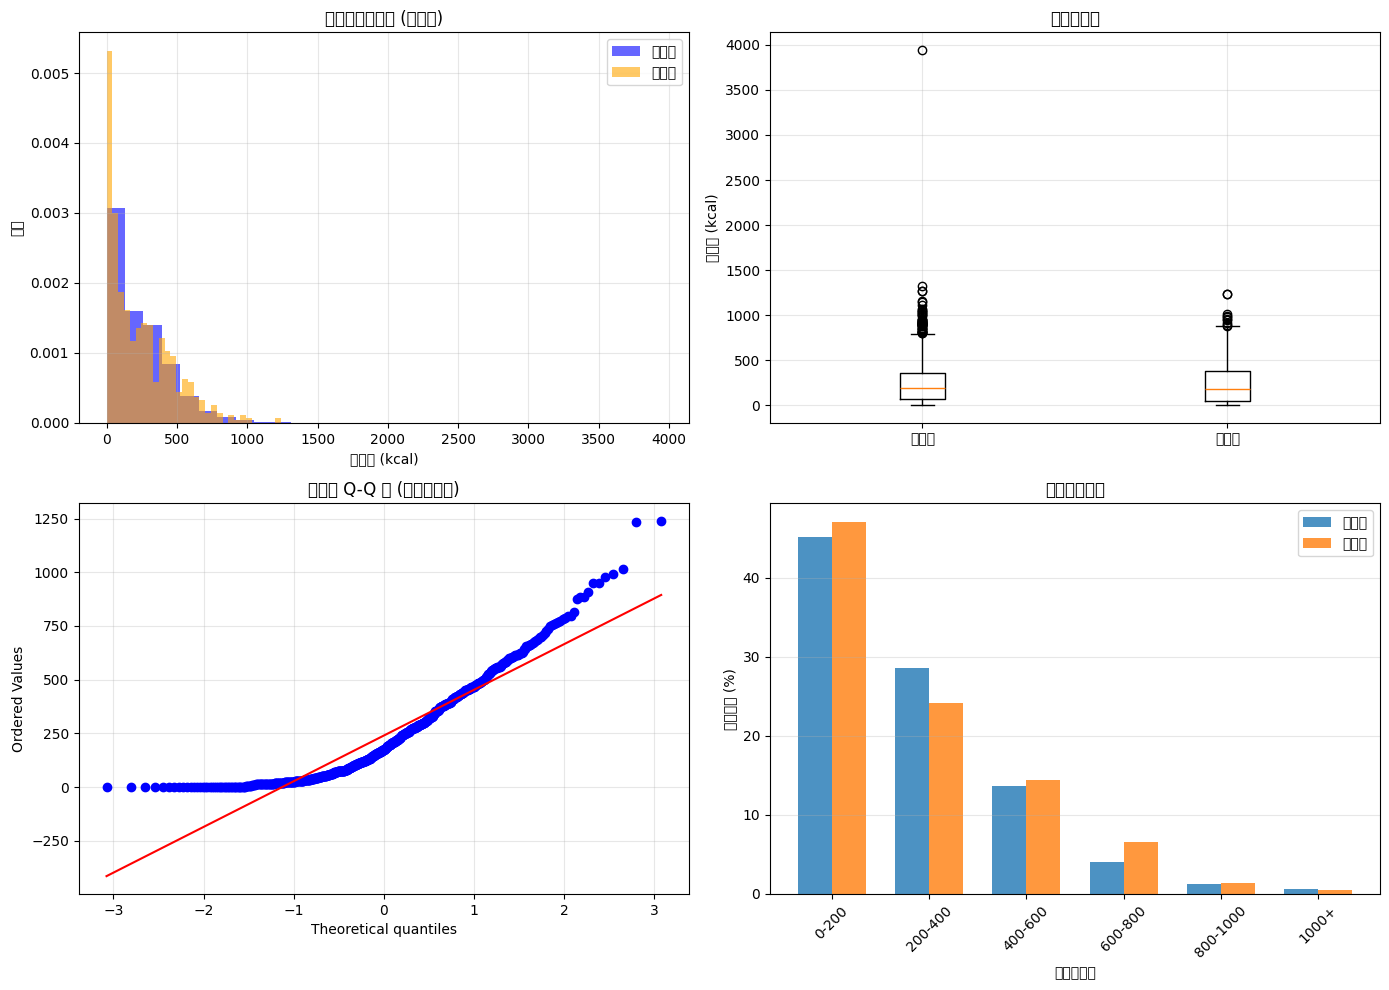

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# ========== 文件路径 ==========
FULL_DATA_PATH = r"C:\Users\HONGRUI\Desktop\cvproject\Nutrition5K\Nutrition5K\nutrition5k_train_clean.csv"
VAL_SPLIT_PATH = r"C:\Users\HONGRUI\Desktop\cvproject\Nutrition5K\Nutrition5K\val_split.csv"
TRAIN_SPLIT_PATH = r"C:\Users\HONGRUI\Desktop\cvproject\Nutrition5K\Nutrition5K\train_split.csv"

print("=" * 70)
print("数据集诊断报告")
print("=" * 70)

# ========== 1. 读取数据并检查列名 ==========
print("\n[1] 读取数据...")
full_df = pd.read_csv(FULL_DATA_PATH)
val_df = pd.read_csv(VAL_SPLIT_PATH)

print(f"\n完整数据集列名: {full_df.columns.tolist()}")
print(f"验证集列名: {val_df.columns.tolist()}")

# 智能识别列名
id_col = None
calorie_col = None

# 查找ID列
for col in full_df.columns:
    if col.lower() in ['id', 'dish_id', 'sample_id']:
        id_col = col
        break

# 查找卡路里列
for col in full_df.columns:
    col_lower = col.lower()
    if col_lower in ['value', 'calories', 'calorie', 'kcal', 'energy', 'total_calories']:
        calorie_col = col
        break

# 如果只有两列，自动推断
if len(full_df.columns) == 2:
    if id_col is None:
        id_col = full_df.columns[0]
    if calorie_col is None:
        calorie_col = full_df.columns[1] if full_df.columns[1] != id_col else full_df.columns[0]

print(f"\n✓ 识别到的列:")
print(f"  ID列: '{id_col}'")
print(f"  卡路里列: '{calorie_col}'")

# 尝试读取train_split
try:
    train_df = pd.read_csv(TRAIN_SPLIT_PATH)
    has_train_split = True
    print("  ✓ 找到train_split.csv")
except FileNotFoundError:
    # 如果没有train_split，用全量减去验证集推断
    train_df = full_df[~full_df[id_col].isin(val_df[id_col])]
    has_train_split = False
    print("  ⚠ 未找到train_split.csv，使用推断的训练集")

print(f"\n样本统计:")
print(f"  完整数据: {len(full_df)} 样本")
print(f"  训练集: {len(train_df)} 样本")
print(f"  验证集: {len(val_df)} 样本")
print(f"  验证集占比: {len(val_df)/len(full_df)*100:.1f}%")

# ========== 2. 基本统计对比 ==========
print("\n[2] 卡路里分布对比")
print("-" * 70)

train_cals = train_df[calorie_col].values
val_cals = val_df[calorie_col].values

stats = pd.DataFrame({
    '训练集': [
        len(train_cals),
        train_cals.mean(),
        train_cals.std(),
        train_cals.min(),
        np.percentile(train_cals, 25),
        np.percentile(train_cals, 50),
        np.percentile(train_cals, 75),
        train_cals.max()
    ],
    '验证集': [
        len(val_cals),
        val_cals.mean(),
        val_cals.std(),
        val_cals.min(),
        np.percentile(val_cals, 25),
        np.percentile(val_cals, 50),
        np.percentile(val_cals, 75),
        val_cals.max()
    ]
}, index=['样本数', '均值', '标准差', '最小值', '25%分位', '中位数', '75%分位', '最大值'])

stats['差异'] = stats['验证集'] - stats['训练集']
stats['差异率%'] = (stats['差异'] / stats['训练集'] * 100).round(2)

print(stats.round(2))

# ========== 3. 分布一致性检验 ==========
print("\n[3] 分布一致性分析")
print("-" * 70)

mean_diff = abs(train_cals.mean() - val_cals.mean())
std_diff = abs(train_cals.std() - val_cals.std())

print(f"均值差异: {mean_diff:.1f} kcal ({mean_diff/train_cals.mean()*100:.1f}%)")
print(f"标准差差异: {std_diff:.1f} kcal ({std_diff/train_cals.std()*100:.1f}%)")

# 警告阈值
warnings = []
if mean_diff > 50:
    warnings.append("⚠⚠⚠ 均值差异过大 (>50 kcal)")
if std_diff > train_cals.std() * 0.2:
    warnings.append("⚠⚠⚠ 标准差差异过大 (>20%)")

for w in warnings:
    print(f"  {w}")

# KS检验
from scipy import stats as sp_stats
ks_stat, ks_pvalue = sp_stats.ks_2samp(train_cals, val_cals)
print(f"\nKS检验统计量: {ks_stat:.4f}, p-value: {ks_pvalue:.4f}")
if ks_pvalue < 0.05:
    print("  ⚠⚠⚠ 警告: 两个分布显著不同 (p<0.05)！")
    warnings.append("分布显著不同")
else:
    print("  ✓ 分布相似性可接受")

# ========== 4. 分段统计 ==========
print("\n[4] 卡路里区间分布")
print("-" * 70)

bins = [0, 200, 400, 600, 800, 1000, float('inf')]
labels = ['0-200', '200-400', '400-600', '600-800', '800-1000', '1000+']

train_bins = pd.cut(train_cals, bins=bins, labels=labels)
val_bins = pd.cut(val_cals, bins=bins, labels=labels)

dist_df = pd.DataFrame({
    '训练集数量': train_bins.value_counts().sort_index(),
    '验证集数量': val_bins.value_counts().sort_index()
})
dist_df['训练集%'] = (dist_df['训练集数量'] / len(train_cals) * 100).round(2)
dist_df['验证集%'] = (dist_df['验证集数量'] / len(val_cals) * 100).round(2)
dist_df['比例差异%'] = (dist_df['验证集%'] - dist_df['训练集%']).round(2)

print(dist_df)

# 检查不平衡
max_diff = dist_df['比例差异%'].abs().max()
max_diff_bin = dist_df['比例差异%'].abs().idxmax()
if max_diff > 5:
    print(f"\n  ⚠⚠⚠ 警告: 区间 [{max_diff_bin}] 比例差异过大 ({max_diff:.1f}%)！")
    warnings.append(f"区间失衡 ({max_diff_bin}: {max_diff:.1f}%)")

# ========== 5. 异常值分析 ==========
print("\n[5] 异常值检测")
print("-" * 70)

def detect_outliers(data, name):
    Q1 = np.percentile(data, 25)
    Q3 = np.percentile(data, 75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    
    outliers = data[(data < lower) | (data > upper)]
    print(f"{name}:")
    print(f"  IQR范围: [{lower:.1f}, {upper:.1f}]")
    print(f"  异常值数量: {len(outliers)} ({len(outliers)/len(data)*100:.2f}%)")
    if len(outliers) > 0:
        print(f"  异常值范围: [{outliers.min():.1f}, {outliers.max():.1f}]")
    return outliers

train_outliers = detect_outliers(train_cals, "训练集")
val_outliers = detect_outliers(val_cals, "验证集")

# ========== 6. 可视化 ==========
print("\n[6] 生成可视化...")

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 6.1 直方图对比
axes[0, 0].hist(train_cals, bins=30, alpha=0.6, label='训练集', color='blue', density=True)
axes[0, 0].hist(val_cals, bins=30, alpha=0.6, label='验证集', color='orange', density=True)
axes[0, 0].set_xlabel('卡路里 (kcal)')
axes[0, 0].set_ylabel('密度')
axes[0, 0].set_title('卡路里分布对比 (归一化)')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# 6.2 箱线图对比
data_to_plot = [train_cals, val_cals]
axes[0, 1].boxplot(data_to_plot, labels=['训练集', '验证集'])
axes[0, 1].set_ylabel('卡路里 (kcal)')
axes[0, 1].set_title('箱线图对比')
axes[0, 1].grid(alpha=0.3)

# 6.3 Q-Q图
from scipy.stats import probplot
probplot(val_cals, dist="norm", plot=axes[1, 0])
axes[1, 0].set_title('验证集 Q-Q 图 (正态性检验)')
axes[1, 0].grid(alpha=0.3)

# 6.4 区间分布对比
x = range(len(labels))
width = 0.35
axes[1, 1].bar([i - width/2 for i in x], dist_df['训练集%'], width, label='训练集', alpha=0.8)
axes[1, 1].bar([i + width/2 for i in x], dist_df['验证集%'], width, label='验证集', alpha=0.8)
axes[1, 1].set_xlabel('卡路里区间')
axes[1, 1].set_ylabel('样本比例 (%)')
axes[1, 1].set_title('区间分布对比')
axes[1, 1].set_xticks(x)
axes[1, 1].set_xticklabels(labels, rotation=45)
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('dataset_diagnosis.png', dpi=150, bbox_inches='tight')
print(f"  ✓ 可视化已保存到 dataset_diagnosis.png")

# ========== 7. 总结与建议 ==========
print("\n" + "=" * 70)
print("诊断总结与建议")
print("=" * 70)

if warnings:
    print("\n❌ 发现的问题:")
    for i, w in enumerate(warnings, 1):
        print(f"  {i}. {w}")
    
    print("\n" + "🔧" * 35)
    print("强烈建议: 使用分层抽样重新划分数据集")
    print("🔧" * 35)
    print(f"\n运行以下代码修复 (使用列名: ID='{id_col}', Value='{calorie_col}'):\n")
    print("```python")
    print("from sklearn.model_selection import train_test_split")
    print("import pandas as pd")
    print()
    print(f"full_df = pd.read_csv(r'{FULL_DATA_PATH}')")
    print(f"full_df['calorie_bin'] = pd.cut(full_df['{calorie_col}'], bins=5, labels=False)")
    print()
    print("train_df, val_df = train_test_split(")
    print("    full_df, test_size=0.15, random_state=42,")
    print("    stratify=full_df['calorie_bin']  # 🔑 关键!")
    print(")")
    print()
    print("train_df.to_csv(r'C:\\Users\\HONGRUI\\Desktop\\cvproject\\Nutrition5K\\Nutrition5K\\train_split_stratified.csv', index=False)")
    print("val_df.to_csv(r'C:\\Users\\HONGRUI\\Desktop\\cvproject\\Nutrition5K\\Nutrition5K\\val_split_stratified.csv', index=False)")
    print("print(f'✓ 新训练集: {len(train_df)} 样本')")
    print("print(f'✓ 新验证集: {len(val_df)} 样本')")
    print("```")
else:
    print("\n✅ 数据集划分质量良好！")
    print("   如果训练仍然不稳定，考虑其他因素:")
    print("   - 降低学习率")
    print("   - 增加正则化")
    print("   - 更换学习率调度器")

print("\n" + "=" * 70)